In [1]:
import pandas as pd
import numpy as np

weather_path_cbr = "../data/nsw/au_canberra_act.csv"
weather_path_syd = "../data/nsw/au_sydney_act.csv"
solar_path = "../data/nsw/au_nsw_iso_satellite_pv_load_act.csv"
total_path_30 = '../data/nsw/au_nsw_total_load_act.csv'
total_path_5 = '../data/nsw/au_nsw_total_load_5_min.csv'
load_path = '../data/nsw/au_nsw_load_act.csv'

# load and store datasets
weather_cbr = pd.read_csv(weather_path_cbr, na_values='-99')
weather_syd = pd.read_csv(weather_path_syd, na_values='-99')
solar = pd.read_csv(solar_path, na_values='-99')
load = pd.read_csv(load_path, na_values='-99')
total_30 = pd.read_csv(total_path_30, na_values='-99')
total_5 = pd.read_csv(total_path_5, na_values='-99', parse_dates=['SETTLEMENTDATE'])

Combine date and time to datetime for datasets where this is necessary - all but `total_5`.

In [2]:
def to_datetime_df(df):
    date = df['date'].astype('str')
    time = df['time'].astype('str').str.pad(4, fillchar='0')
    df['datetime'] = pd.to_datetime(date + time, format = '%Y%m%d%H%M')
    df_d = df.drop(['date', 'time'], axis = 1)
    return df_d

weather_cbr_d = to_datetime_df(weather_cbr)
weather_syd_d = to_datetime_df(weather_syd)
solar_d = to_datetime_df(solar)
load_d = to_datetime_df(load)
total_30_d = to_datetime_df(total_30)
total_5_d = total_5.rename({'SETTLEMENTDATE': 'datetime', 'TOTALDEMAND': 'load_act'}, axis=1).drop('RRP', axis=1)

Fix NAs and the latent 5-min step observations in the 30-min step total load data

In [3]:
print('NAs in 30-min file:', total_30_d['load_act'].isna().sum(), 'of', total_30_d.shape[0])
#actually_30 = total_30_d['datetime'].shift(-1) - total_30_d['datetime'] == pd.Timedelta('30m')
actually_30 = ~(total_30_d.diff()['datetime'] == pd.Timedelta('5m'))

total_30_actual = total_30_d[actually_30]
total_30_5 = total_30_d[~actually_30]

print('NAs in 30-min subset:', total_30_actual['load_act'].isna().sum(), 'of', total_30_actual.shape[0],
    'range', total_30_actual['datetime'].describe(datetime_is_numeric=True)[['min', 'max']].values)

total_30_actual_nas = total_30_actual.loc[total_30_actual['load_act'].isna(), 'datetime']
print('30-min NAs:', total_30_actual_nas.shape[0], 'in range', total_30_actual_nas.describe(datetime_is_numeric=True)[['min', 'max']].values)

print('NAs in 5-min subset:', total_30_5['load_act'].isna().sum(), 'of', total_30_5.shape[0],
    'in range', total_30_5['datetime'].describe(datetime_is_numeric=True)[['min', 'max']].values)

total_30_5_nas = total_30_5.loc[total_30_5['load_act'].isna(), 'datetime']
print('5-min NA range:', total_30_5_nas.shape[0], 'in range', total_30_5_nas.describe(datetime_is_numeric=True)[['min', 'max']].values)


NAs in 30-min file: 24623 of 194784
NAs in 30-min subset: 24623 of 128545 range [Timestamp('2016-01-01 00:00:00') Timestamp('2022-11-09 00:00:00')]
30-min NAs: 24623 in range [Timestamp('2021-10-01 00:30:00') Timestamp('2022-11-08 23:30:00')]
NAs in 5-min subset: 0 of 66239 in range [Timestamp('2021-10-01 00:10:00') Timestamp('2022-05-19 00:00:00')]
5-min NA range: 0 in range [NaT NaT]


Looks like we are stuck with the NAs in the range of 2022-05-19 to 2022-11-08.

Unless........ a script were to exist that could `retrieve.sh` the raw values from AEMO.

In [4]:
scripted_total = pd.read_csv('../data/nsw/demand_nsw_201601_202307.csv', na_values='-99')
scripted_total['datetime'] = pd.to_datetime(scripted_total['SETTLEMENTDATE'])
scripted_total.drop(['REGION', 'RRP', 'PERIODTYPE', 'SETTLEMENTDATE'], axis=1, inplace=True)
scripted_total.rename({'TOTALDEMAND': 'total_load'}, axis=1, inplace=True)
print('NAs in script-retrieved total load:', scripted_total['total_load'].isna().sum())
scripted_total.describe(datetime_is_numeric=True)

NAs in script-retrieved total load: 0


,total_load,datetime
count,293472.000000,293472
mean,7680.646296,2021-05-12 23:09:33.650638592
min,3957.320000,2016-01-01 00:30:00
25%,6742.987500,2020-03-08 12:22:30
50%,7539.670000,2022-03-09 12:02:30
75%,8415.215000,2022-11-19 06:01:15
max,13985.870000,2023-08-01 00:00:00
std,1287.553396,NaN


Fantastic. Now a single dataframe without missing values covers the full range of desired dates.

Weather data is hourly, so average up total, net, and pv load observations to hourly, then concatenate the older 30-min total load frame with the newer 5-min total load.

In [5]:
solar_hour = solar_d.set_index('datetime').resample(rule='H', closed='right', label='right').mean()
load_hour = load_d.set_index('datetime').resample(rule='H', closed='right', label='right').mean()
total_hour = scripted_total.set_index('datetime').resample('H', closed='right', label='right').mean()

Now rename columns in preparation for join

In [6]:
load_hour.rename({'load_act': 'net_load'}, axis=1, inplace=True)
solar_hour.rename({'load_act': 'pv_est'}, axis=1, inplace=True)
weather_cbr_d.columns = [f'{x}_cbr' for x in weather_cbr_d.columns[:-1]] + ['datetime']
weather_syd_d.columns = [f'{x}_syd' for x in weather_syd_d.columns[:-1]] + ['datetime']

load_hour.columns, total_hour.columns, solar_hour.columns, weather_cbr_d.columns, weather_syd_d.columns

(Index(['net_load'], dtype='object'),
 Index(['total_load'], dtype='object'),
 Index(['pv_est'], dtype='object'),
 Index(['tempc_cbr', 'cloud8_cbr', 'windk_cbr', 'wdir_cbr', 'humid_cbr',
        'rainmm_cbr', 'radkjm2_cbr', 'datetime'],
       dtype='object'),
 Index(['tempc_syd', 'cloud8_syd', 'windk_syd', 'wdir_syd', 'humid_syd',
        'rainmm_syd', 'radkjm2_syd', 'datetime'],
       dtype='object'))

In [7]:
load_total = load_hour.merge(total_hour, left_index=True, right_index=True, copy=False, validate='1:1')
load_total_pv = load_total.merge(solar_hour, left_index=True, right_index=True, copy=False, validate='1:1')
load_cbr = load_total_pv.reset_index().merge(weather_cbr_d, on='datetime', copy=False, validate='1:1')
merged = load_cbr.merge(weather_syd_d, on='datetime', copy=False, validate='1:1')
merged.head()

,datetime,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,radkjm2_cbr,tempc_syd,cloud8_syd,windk_syd,wdir_syd,humid_syd,rainmm_syd,radkjm2_syd
0,2018-03-06 10:00:00,8499.5,8332.145,434.3715,19.0,2.0,15.0,110.0,52.0,0.0,2250.0,21.1,3.0,21.004327,190.0,71.0,0.0,1710.0
1,2018-03-06 11:00:00,8457.0,8294.325,468.8860,19.4,1.0,14.0,140.0,49.0,0.0,2860.0,21.7,3.0,19.978409,180.0,71.0,0.0,2080.0
2,2018-03-06 12:00:00,8396.0,8248.405,483.1315,19.1,4.0,15.0,150.0,52.0,0.0,2650.0,22.1,3.0,21.976250,180.0,65.0,0.0,2760.0
3,2018-03-06 13:00:00,8341.5,8193.080,491.4175,19.4,4.0,14.0,140.0,55.0,0.0,2710.0,22.6,4.0,20.950332,180.0,67.0,0.0,2840.0
4,2018-03-06 14:00:00,8321.5,8185.100,487.9780,18.9,7.0,17.0,120.0,57.0,0.0,1730.0,23.0,2.0,20.950332,180.0,65.0,0.0,2850.0


Ensure result is sorted by timestamp.

In [8]:
merged.sort_values(by='datetime', inplace=True)

Plot all columns against timestamp as a sanity check.

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

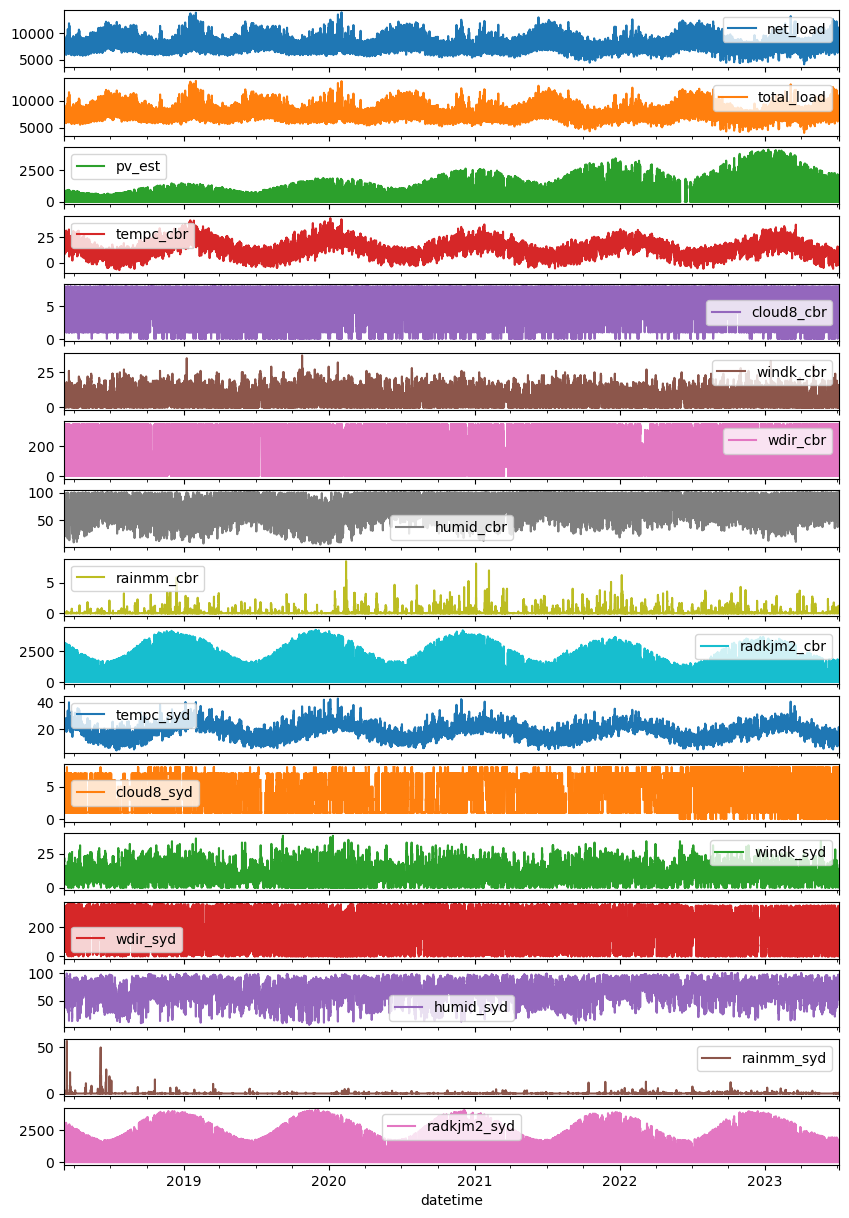

In [9]:
merged.plot(x='datetime', subplots=True, figsize=(10, 15))

In [10]:
merged.describe().round()

,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,radkjm2_cbr,tempc_syd,cloud8_syd,windk_syd,wdir_syd,humid_syd,rainmm_syd,radkjm2_syd
count,46752.0,46752.0,46204.0,46740.0,46740.0,46740.0,46740.0,46740.0,46717.0,46740.0,46660.0,31497.0,46663.0,46662.0,46663.0,46648.0,46740.0
mean,7835.0,7742.0,454.0,13.0,6.0,7.0,169.0,71.0,0.0,598.0,18.0,5.0,11.0,191.0,68.0,0.0,665.0
std,1259.0,1254.0,696.0,7.0,2.0,5.0,124.0,22.0,0.0,894.0,5.0,2.0,6.0,108.0,18.0,1.0,950.0
min,4130.0,4023.0,0.0,-7.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,6.0,0.0,0.0
25%,6928.0,6836.0,0.0,8.0,4.0,4.0,60.0,55.0,0.0,0.0,15.0,2.0,7.0,100.0,56.0,0.0,0.0
50%,7700.0,7602.0,23.0,13.0,6.0,6.0,140.0,75.0,0.0,30.0,19.0,5.0,10.0,200.0,70.0,0.0,40.0
75%,8556.0,8455.0,719.0,18.0,8.0,10.0,300.0,90.0,0.0,960.0,22.0,7.0,14.0,290.0,82.0,0.0,1160.0
max,13806.0,13654.0,4146.0,43.0,8.0,37.0,350.0,100.0,8.0,4200.0,42.0,8.0,38.0,360.0,100.0,56.0,4070.0


In [11]:
merged.isna().mean()

datetime       0.000000
net_load       0.000000
total_load     0.000000
pv_est         0.011721
tempc_cbr      0.000257
cloud8_cbr     0.000257
windk_cbr      0.000257
wdir_cbr       0.000257
humid_cbr      0.000257
rainmm_cbr     0.000749
radkjm2_cbr    0.000257
tempc_syd      0.001968
cloud8_syd     0.326296
windk_syd      0.001904
wdir_syd       0.001925
humid_syd      0.001904
rainmm_syd     0.002225
radkjm2_syd    0.000257
dtype: float64

Write to file.

In [12]:
merged.to_csv('../data/nsw/merged.csv', index=False)

In case we want to compare against a 30-minute timestep with weather variables upsampled via interpolation..

In [13]:
solar_30 = solar_d.set_index('datetime')
load_30 = load_d.set_index('datetime')
total_30_real = scripted_total.set_index('datetime').resample('30min', closed='right', label='right').mean()

In [14]:
load_30.rename({'load_act': 'net_load'}, axis=1, inplace=True)
solar_30.rename({'load_act': 'pv_est'}, axis=1, inplace=True)
weather_cbr_30 = weather_cbr_d.set_index('datetime').resample('30min').asfreq().interpolate()
weather_syd_30 = weather_syd_d.set_index('datetime').resample('30min').asfreq().interpolate()

load_hour.columns, total_hour.columns, solar_hour.columns, weather_cbr_30.columns, weather_syd_30.columns

(Index(['net_load'], dtype='object'),
 Index(['total_load'], dtype='object'),
 Index(['pv_est'], dtype='object'),
 Index(['tempc_cbr', 'cloud8_cbr', 'windk_cbr', 'wdir_cbr', 'humid_cbr',
        'rainmm_cbr', 'radkjm2_cbr'],
       dtype='object'),
 Index(['tempc_syd', 'cloud8_syd', 'windk_syd', 'wdir_syd', 'humid_syd',
        'rainmm_syd', 'radkjm2_syd'],
       dtype='object'))

In [15]:
load_total_30 = load_30.merge(total_30_real, left_index=True, right_index=True, copy=False, validate='1:1')
load_total_pv_30 = load_total_30.merge(solar_30, left_index=True, right_index=True, copy=False, validate='1:1')
load_cbr_30 = load_total_pv_30.reset_index().merge(weather_cbr_30, on='datetime', copy=False, validate='1:1')
merged_30 = load_cbr_30.merge(weather_syd_30, on='datetime', copy=False, validate='1:1')
merged_30.head()

,datetime,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,radkjm2_cbr,tempc_syd,cloud8_syd,windk_syd,wdir_syd,humid_syd,rainmm_syd,radkjm2_syd
0,2018-03-06 09:30:00,8503,8325.67,417.157,18.30,3.5,13.5,115.0,54.0,0.0,1720.0,21.35,3.5,20.005406,175.0,66.0,2.5,1390.0
1,2018-03-06 10:00:00,8496,8338.62,451.586,19.00,2.0,15.0,110.0,52.0,0.0,2250.0,21.10,3.0,21.004327,190.0,71.0,0.0,1710.0
2,2018-03-06 10:30:00,8467,8323.66,460.385,19.20,1.5,14.5,125.0,50.5,0.0,2555.0,21.40,3.0,20.491368,185.0,71.0,0.0,1895.0
3,2018-03-06 11:00:00,8447,8264.99,477.387,19.40,1.0,14.0,140.0,49.0,0.0,2860.0,21.70,3.0,19.978409,180.0,71.0,0.0,2080.0
4,2018-03-06 11:30:00,8404,8247.11,485.900,19.25,2.5,14.5,145.0,50.5,0.0,2755.0,21.90,3.0,20.977329,180.0,68.0,0.0,2420.0


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

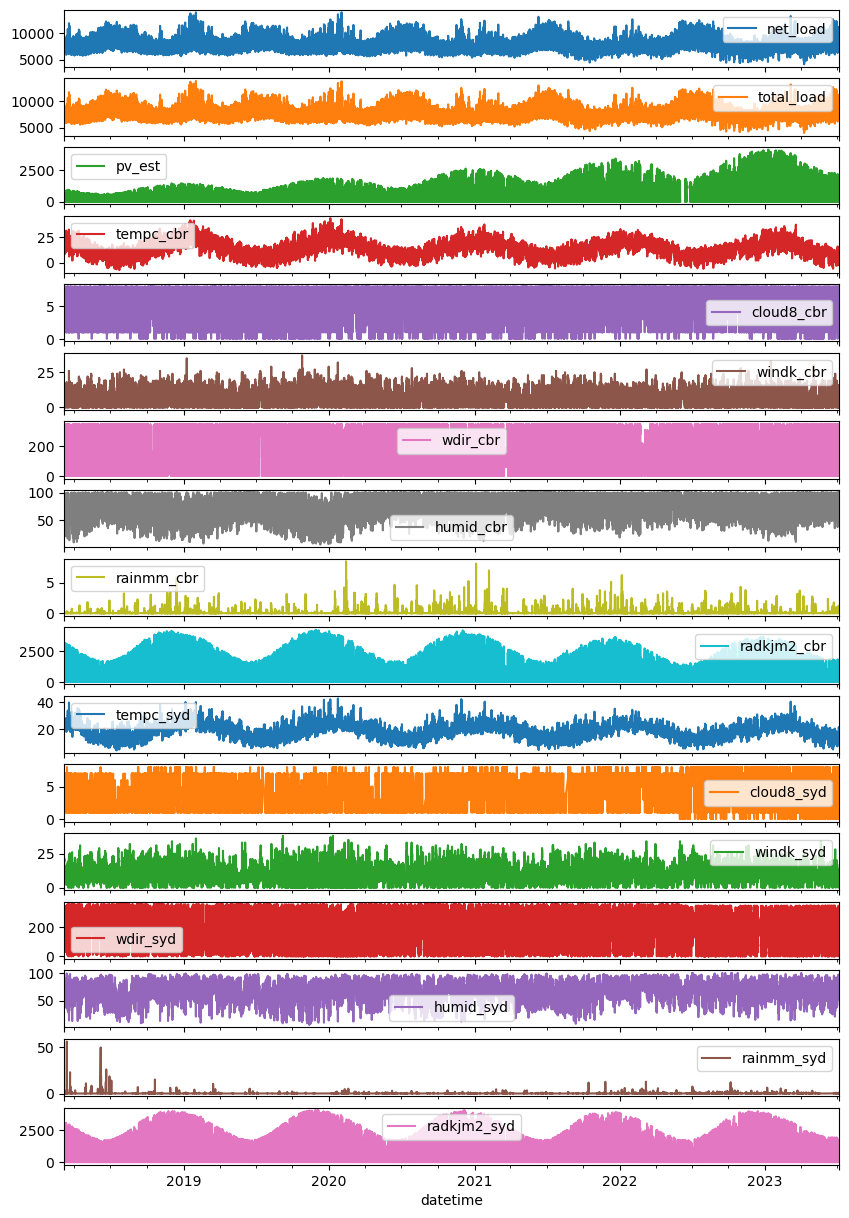

In [16]:
merged_30.sort_values(by='datetime', inplace=True)
merged_30.plot(x='datetime', subplots=True, figsize=(10, 15))

Compute percent difference between hourly and half-hourly data with interpolated weather

In [17]:
((merged.describe() - merged_30.describe()) / merged.describe()).round(3)

,net_load,total_load,pv_est,tempc_cbr,cloud8_cbr,windk_cbr,wdir_cbr,humid_cbr,rainmm_cbr,radkjm2_cbr,tempc_syd,cloud8_syd,windk_syd,wdir_syd,humid_syd,rainmm_syd,radkjm2_syd
count,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.001,-1.000,-1.004,-1.969,-1.004,-1.004,-1.004,-1.004,-1.000
mean,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.118,-0.000,0.000,-0.000,-0.012,-0.000
std,-0.004,-0.004,-0.003,0.003,0.043,0.021,0.053,0.006,0.034,0.011,0.002,0.024,0.017,0.035,0.006,-0.007,0.008
min,0.007,0.006,NaN,-0.000,NaN,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,NaN,0.000,NaN,NaN
25%,0.001,0.001,NaN,0.006,0.000,0.125,-0.250,-0.009,NaN,NaN,0.000,0.250,0.066,-0.100,0.000,NaN,NaN
50%,0.000,-0.000,0.348,0.004,0.000,0.000,-0.071,0.007,NaN,-0.833,0.000,0.200,0.048,0.050,0.000,NaN,-0.750
75%,0.000,-0.000,-0.003,0.000,0.000,0.000,0.000,0.006,NaN,-0.010,0.000,0.107,-0.002,0.017,0.000,NaN,0.000
max,-0.002,-0.003,-0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [18]:
merged_30.isna().mean()

datetime       0.00000
net_load       0.00000
total_load     0.00000
pv_est         0.01185
tempc_cbr      0.00000
cloud8_cbr     0.00000
windk_cbr      0.00000
wdir_cbr       0.00000
humid_cbr      0.00000
rainmm_cbr     0.00000
radkjm2_cbr    0.00000
tempc_syd      0.00000
cloud8_syd     0.00000
windk_syd      0.00000
wdir_syd       0.00000
humid_syd      0.00000
rainmm_syd     0.00000
radkjm2_syd    0.00000
dtype: float64

Most of the difference is probably the interpolation filling in ranges of missing values. Probably.

In [19]:
merged_30.to_csv('../data/nsw/merged_interpolated.csv', index=False)